## Using Spectral Clustering to Detect Weather Clusters

In [178]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 
from scipy.spatial import distance

In [241]:
# code from hw3
def full_kmeans(data, k):
    km_alg = KMeans(n_clusters=k)
    fit1 = km_alg.fit(data)
    labels = fit1.labels_
    centers = fit1.cluster_centers_
    
    return labels, centers

# Question 2
def make_adj(array_np):
    pair_dists = distance.cdist(array_np, array_np, 'euclidean')
    
    # adapted from:
    # https://www.geeksforgeeks.org/python-replace-negative-value-with-zero-in-numpy-array/
    pair_dists[pair_dists < 0.5] = 0.3 # placeholder so doesn't get set to 0
    pair_dists[pair_dists >= 0.5] = 0 
    pair_dists[pair_dists > 0] = 1 # undo placeholder
    
    # make sure diagonals are 0
    # from https://numpy.org/doc/stable/reference/generated/numpy.fill_diagonal.html
    np.fill_diagonal(pair_dists, 0)
    
    return pair_dists
    
def my_laplacian(A):
    '''returns unnormalized Laplacian of numpy array/adjacency list'''
    # https://numpy.org/doc/stable/reference/generated/numpy.sum.html
    rowSums = np.sum(A, axis = 1)

    # degree matrix
    # counts num datapoints each datapoint near
    # https://numpy.org/doc/stable/reference/generated/numpy.diag.html
    D = np.diag(rowSums)

    # unnormalized Laplacian
    L = D - A

    return L

# Question 3
def spect_clustering(L, k):
    # eigens of L
    eig_vals, eig_vecs = np.linalg.eig(L)
    # prevent complex numbers
    # https://numpy.org/doc/stable/reference/generated/numpy.real.html
    eig_vals = np.real(eig_vals)
    eig_vecs = np.real(eig_vecs)
    print("eigvals", eig_vals)
    print("eigvecs", eig_vecs)
    
    # sort smallest to greatest eigenvalue
    inds = eig_vals.argsort()
    eig_vals = eig_vals[inds]
    eig_vecs = eig_vecs[:,inds]
    print("eigvec shape", eig_vecs.shape)
    
    # find non-zero eigenvalues only
    # https://numpy.org/doc/stable/reference/generated/numpy.argwhere.html
    # pointed me to np.nonzero()
    nonZinds = np.nonzero(eig_vals)
    eig_vals = eig_vals[nonZinds]
    eig_vecs = eig_vecs[nonZinds]
    
    # first k eigenvectors
    k_eig_vecs = eig_vecs[:, :k]
    
    print("keigvec shape", k_eig_vecs.shape)
    
    return full_kmeans(k_eig_vecs, k)

# code from lab 6
def standardize(data):
    '''Standardize a dataframe'''
    mean_vec = np.mean(data, axis=0)
    sd_vec = np.std(data, axis=0)

    data_std = data.copy()
    for i in range(data.shape[1]): # for every column
        data_std[:,i] = (data[:,i] - mean_vec[i]*np.ones(data.shape[0]))/sd_vec[i]
        
    return data_std

## Using Weather Data for Raleigh, NC

What weather clusters come up when we remove temporal indicators, such as dates and seasons?

In [180]:
# import data
weather_pd = pd.read_csv('../data/weather.csv', index_col = 0)
weather_pd = weather_pd.drop(['YEAR', 'MONTH', 'DAY', 'SEASON', 'STP', 'GUST', 'SNDP'], axis=1) # remove temporal indicators

# drop station pressure bc redundant with sea level and not collected in 2000, 2002, 2004
# and drop max gust because missing for half the days and somewhat redundant w/ mxspd

In [181]:
weather_pd.head()

,TEMP,DEWP,SLP,VISIB,WDSP,MXSPD,MAX,MIN,PRCP
0,47.6,38.1,1023.7,8.3,3.0,10.1,66.9,33.1,0.00
1,55.3,46.3,1024.2,9.5,4.8,14.0,70.0,33.1,0.00
2,62.6,55.4,1021.3,8.4,8.5,14.0,73.9,43.0,0.00
3,65.2,58.6,1014.4,9.5,15.3,28.0,73.9,55.0,0.00
4,45.7,30.9,1019.8,9.8,6.4,11.1,57.9,37.0,0.34


<IPython.core.display.Javascript object>


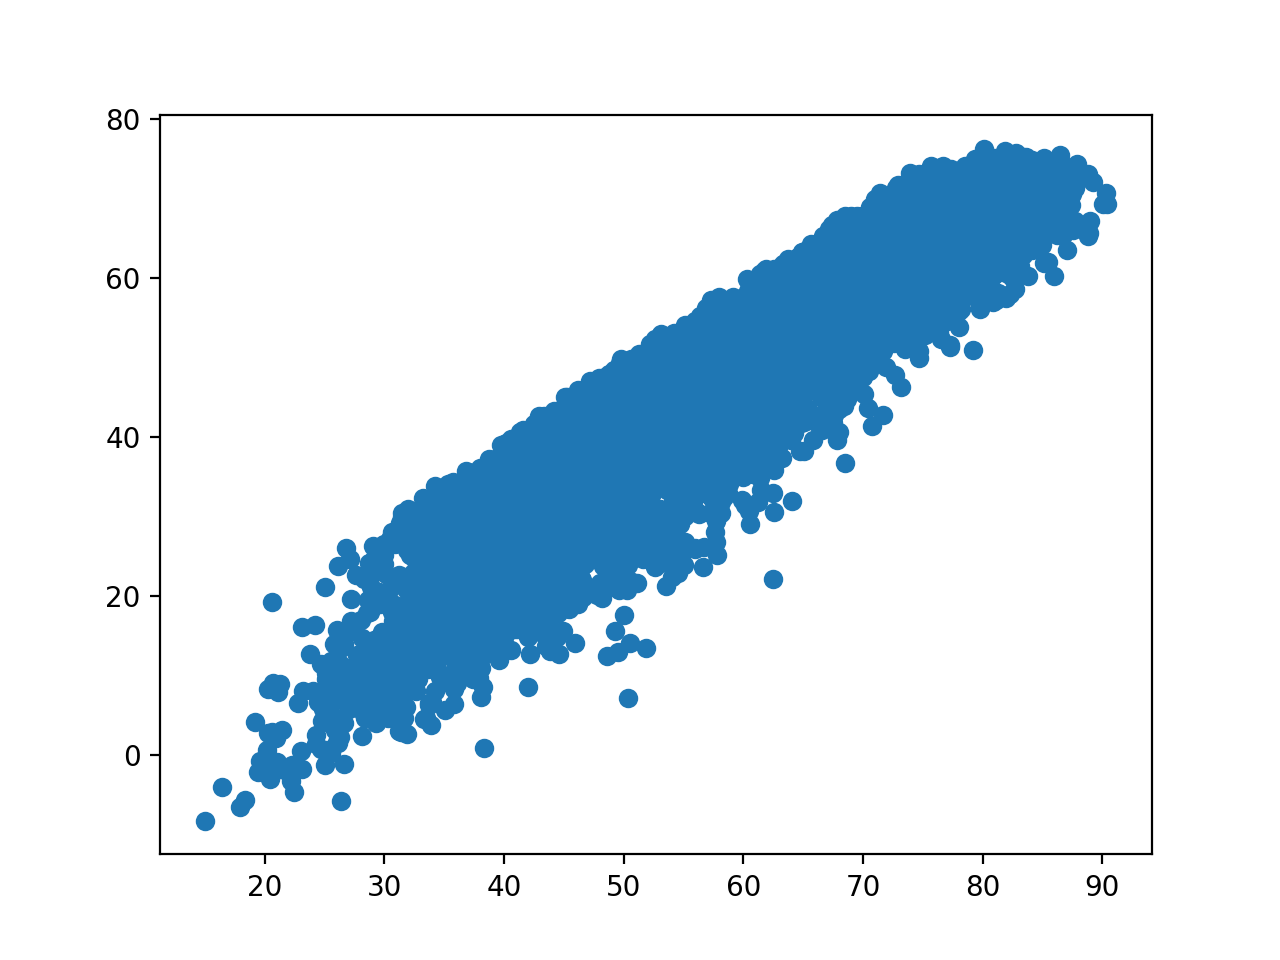

In [184]:
plt.scatter(weather_pd['TEMP'], weather_pd['DEWP'])

<IPython.core.display.Javascript object>


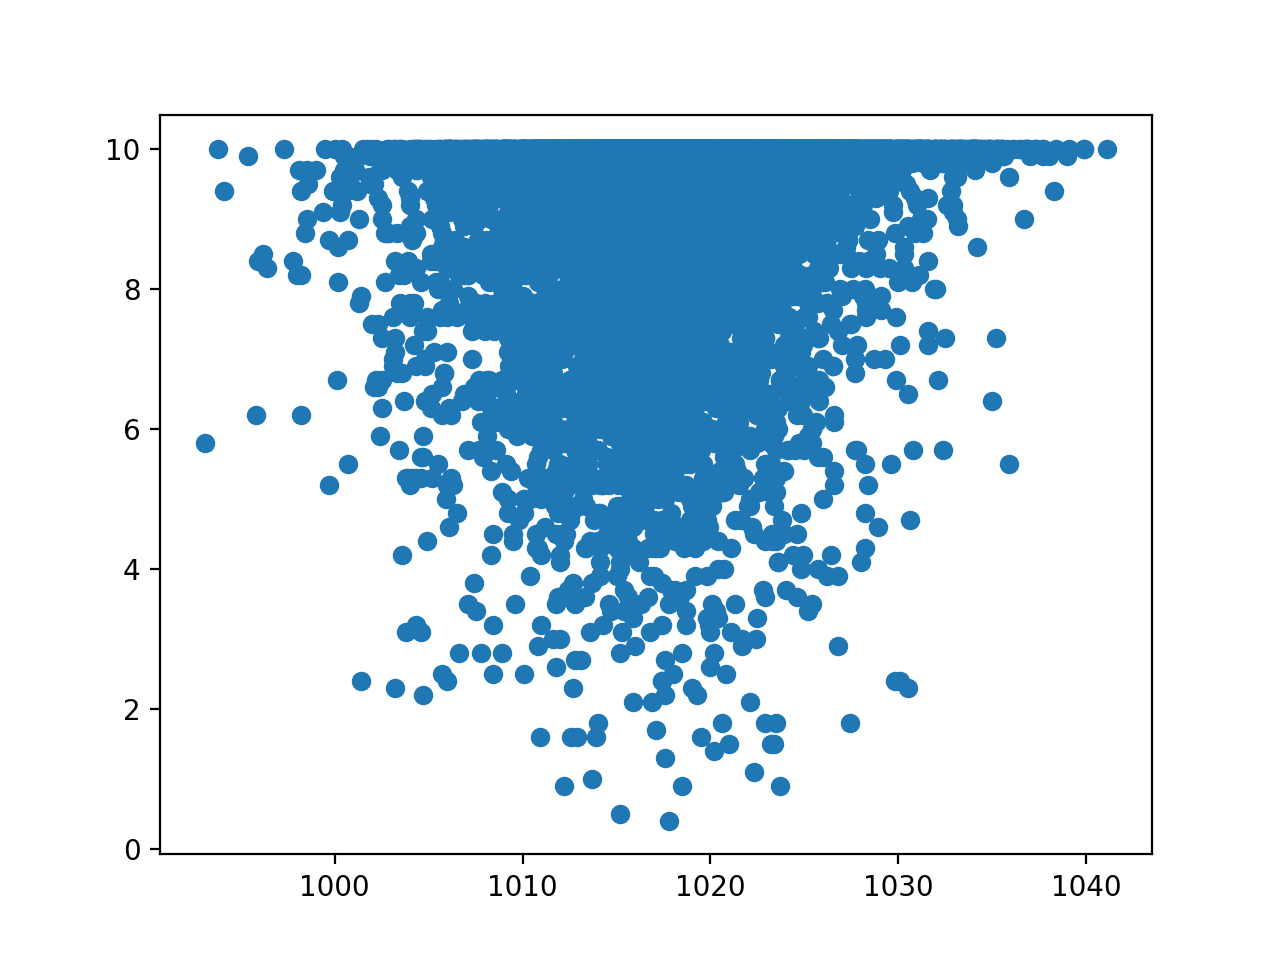

In [185]:
plt.scatter(weather_pd['SLP'], weather_pd['VISIB'])

<IPython.core.display.Javascript object>


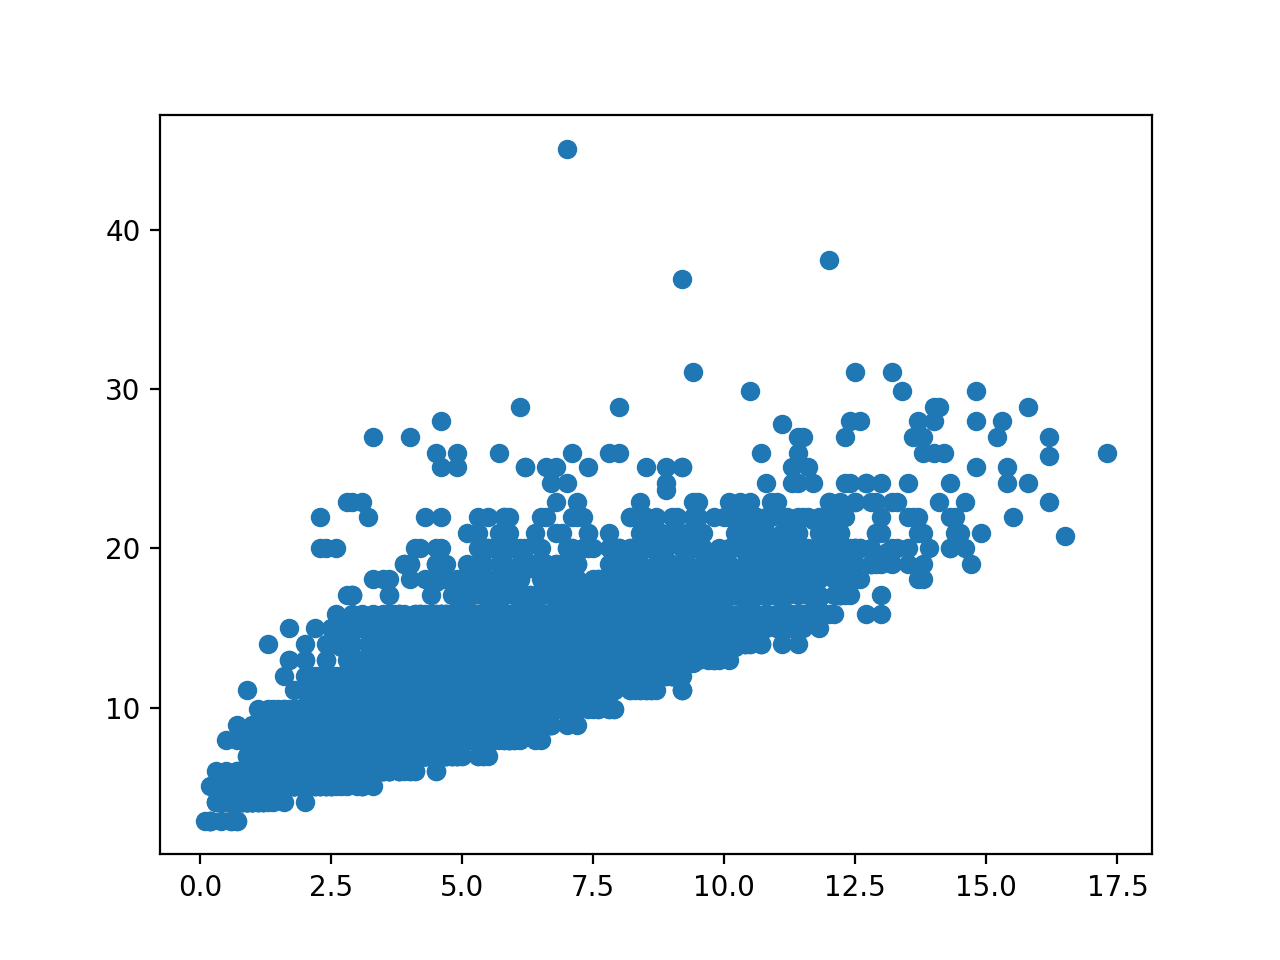

In [186]:
plt.scatter(weather_pd['WDSP'], weather_pd['MXSPD'])

<IPython.core.display.Javascript object>


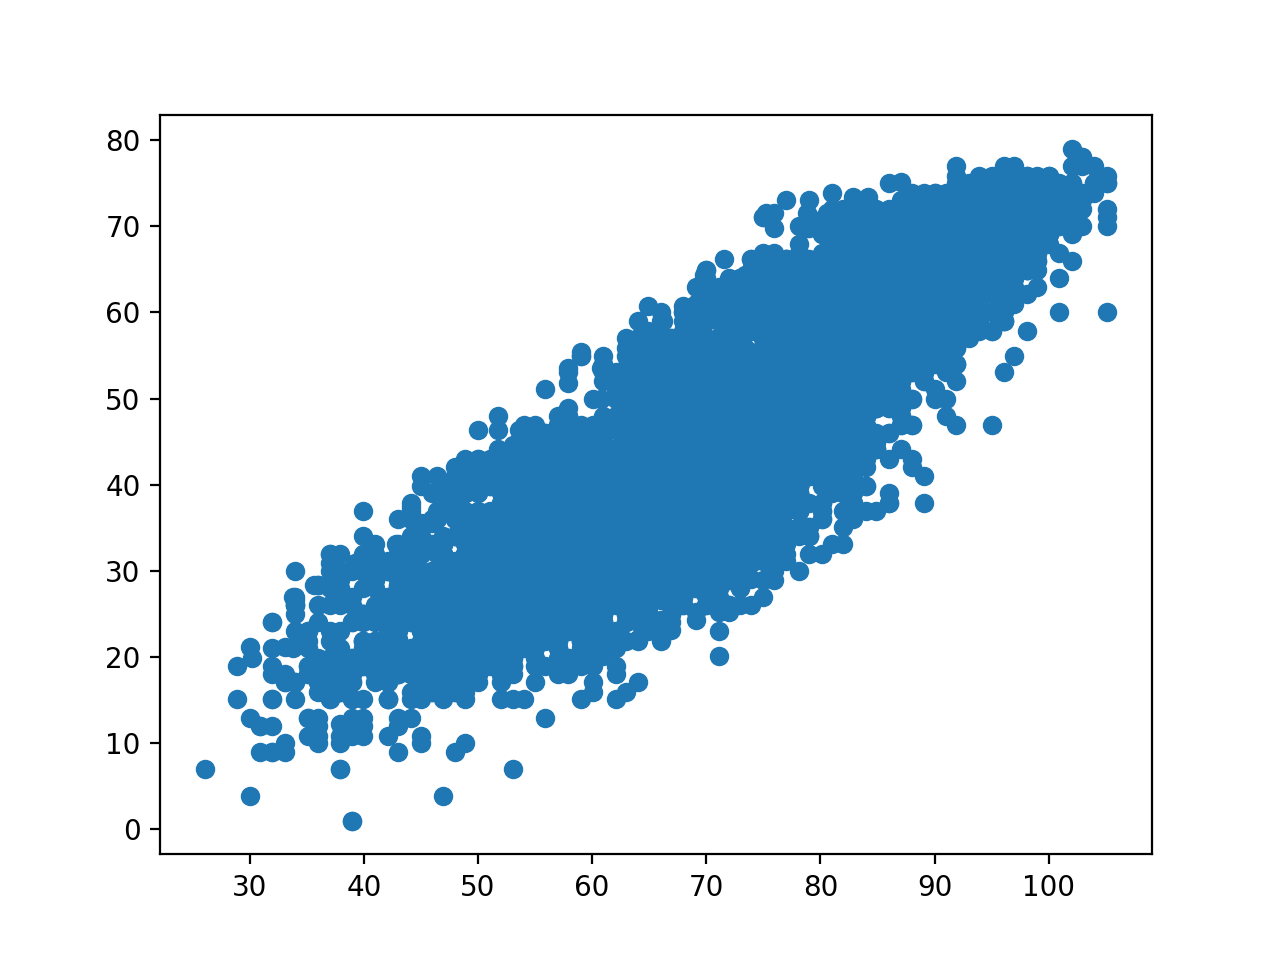

In [187]:
plt.scatter(weather_pd['MAX'], weather_pd['MIN'])

In [189]:
#plt.scatter(weather_pd['PRCP'], weather_pd['SNDP'])

<IPython.core.display.Javascript object>


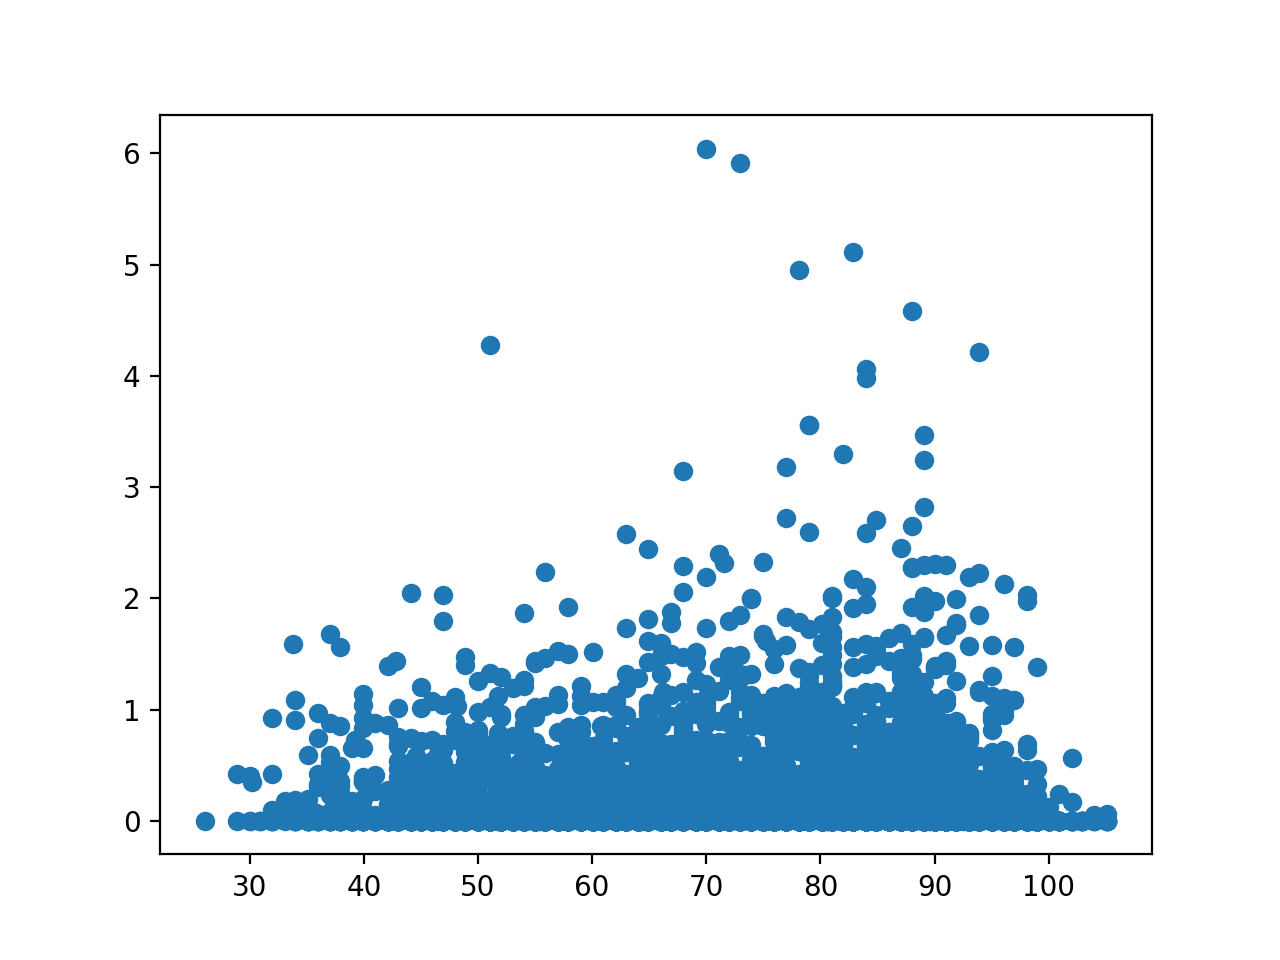

In [190]:
plt.scatter(weather_pd['MAX'], weather_pd['PRCP'])

In [231]:
# convert to numpy
weather = weather_pd.to_numpy()
weather_std = standardize(weather)
# not forgetting to standardize, sklearn PCA does it automatically

## Take a look in 2D

In [232]:
# use PCA to plot in 2D
pca = PCA(n_components=2)
weather_two = pca.fit_transform(weather_std)

<IPython.core.display.Javascript object>


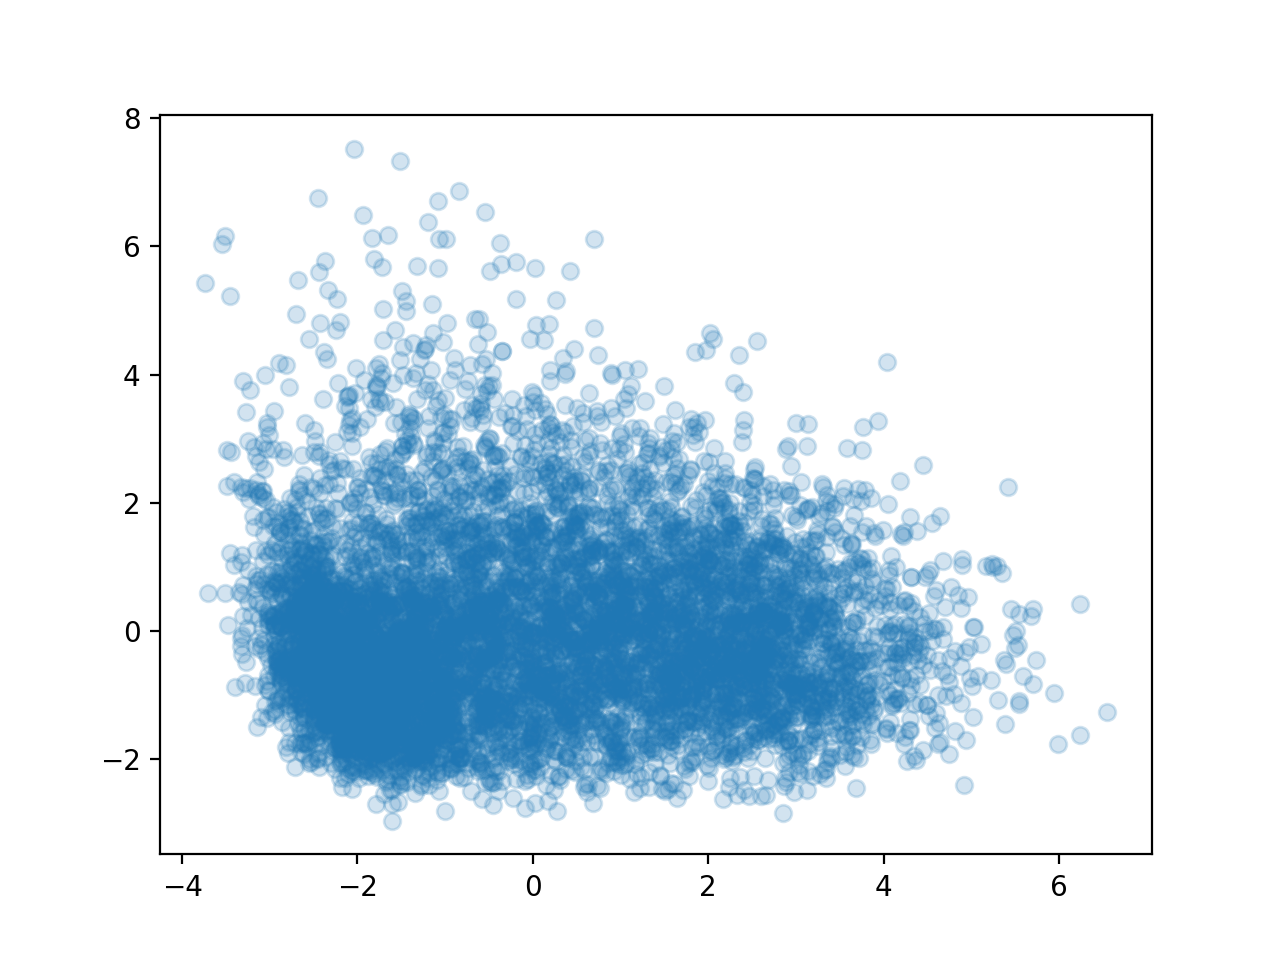

In [233]:
plt.scatter(weather_two[:,0], weather_two[:,1], alpha=0.2)

In [194]:
weather_two.shape

(7772, 2)

## Take a look in 3D

<IPython.core.display.Javascript object>


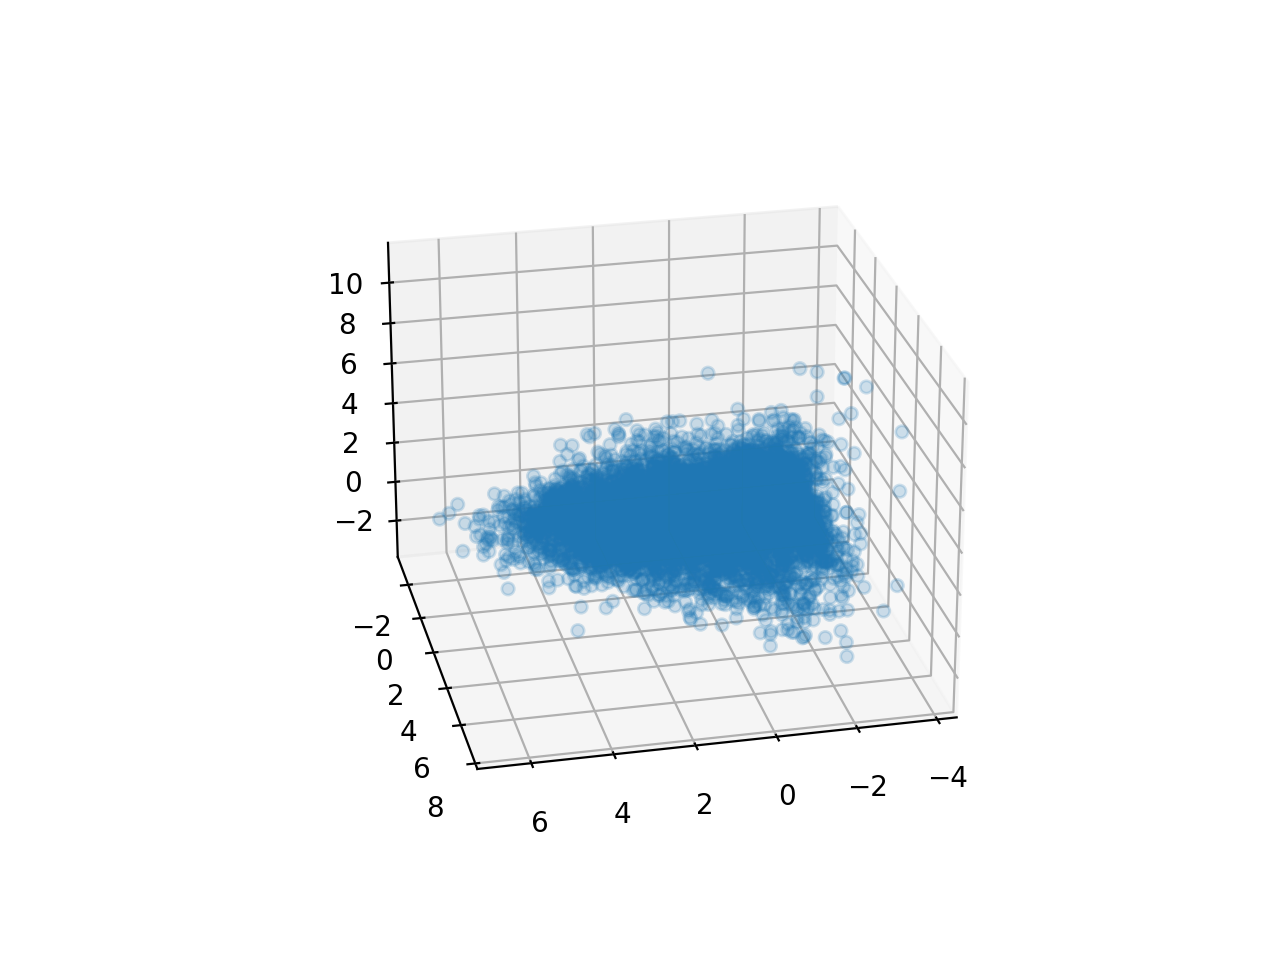

In [234]:
pca = PCA(n_components=3)
weather_two = pca.fit_transform(weather_std)

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(weather_two[:,0], weather_two[:,1], weather_two[:,2], alpha=0.2)

## Find Clusters with Spectral Clustering

In [235]:
weather.shape
L.shape

(7772, 7772)

In [236]:
weather

array([[4.7600e+01, 3.8100e+01, 1.0237e+03, ..., 6.6900e+01, 3.3100e+01,
        0.0000e+00],
       [5.5300e+01, 4.6300e+01, 1.0242e+03, ..., 7.0000e+01, 3.3100e+01,
        0.0000e+00],
       [6.2600e+01, 5.5400e+01, 1.0213e+03, ..., 7.3900e+01, 4.3000e+01,
        0.0000e+00],
       ...,
       [7.1700e+01, 6.4000e+01, 1.0091e+03, ..., 8.7100e+01, 6.3000e+01,
        2.0000e-01],
       [6.4100e+01, 4.7400e+01, 1.0153e+03, ..., 8.4900e+01, 5.5000e+01,
        0.0000e+00],
       [5.1600e+01, 4.7200e+01, 1.0138e+03, ..., 5.7900e+01, 4.6900e+01,
        0.0000e+00]])

In [237]:
A = make_adj(weather_std)
L = my_laplacian(A)

In [242]:
labels, centers = spect_clustering(L, 2)

eigvals [26.69088694 25.49926408 25.39363929 ...  0.          0.
  0.        ]
eigvecs [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.93870742e-18 -4.35390826e-20 -3.28096696e-18 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 5.63959433e-14  1.56241819e-11 -5.54022623e-11 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]
eigvec shape (7772, 7772)
keigvec shape (3557, 2)


In [245]:
labels.shape

(3557,)

<IPython.core.display.Javascript object>


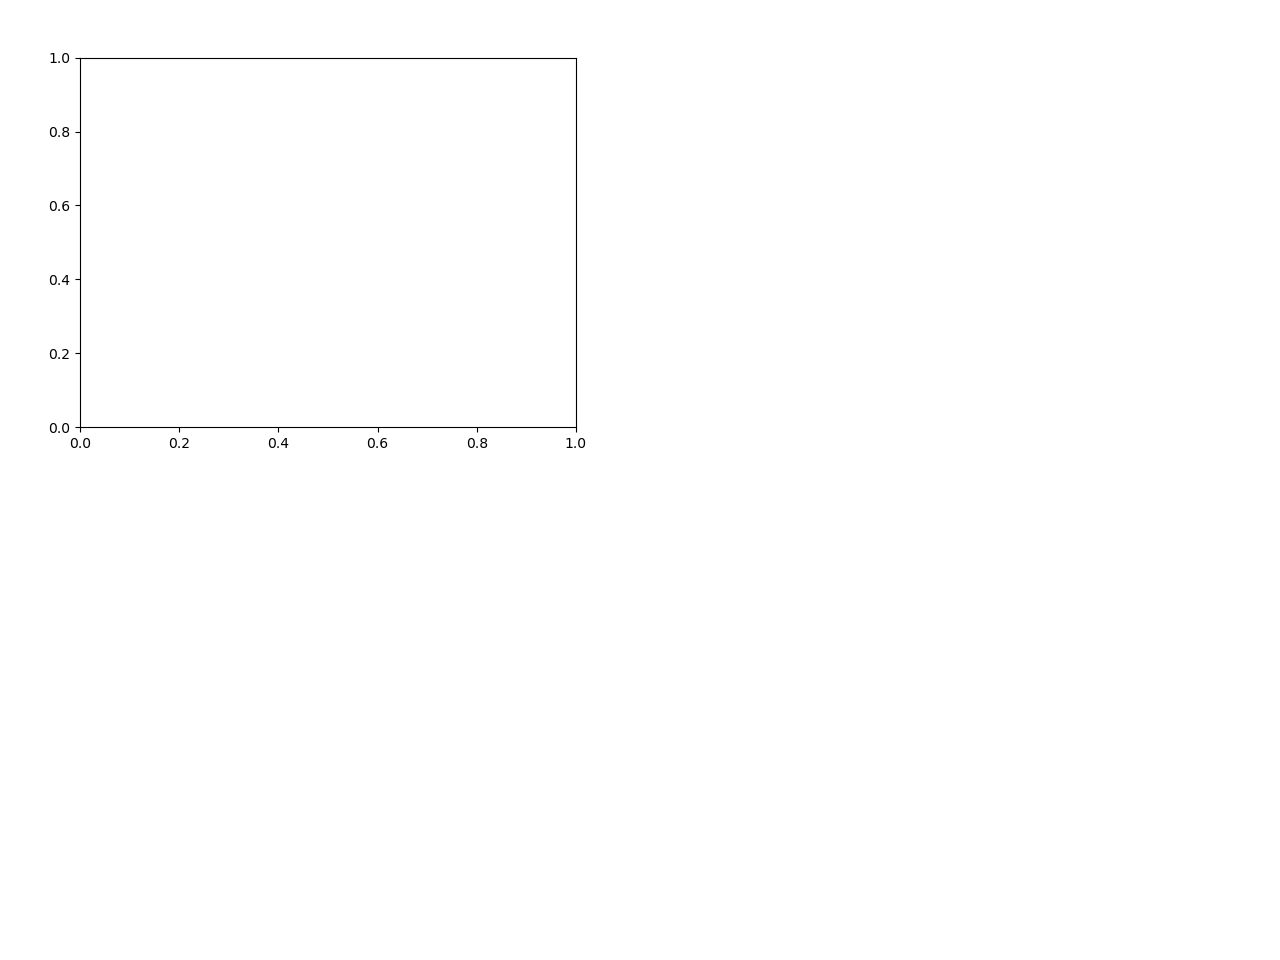

ValueError: 'c' argument has 3557 elements, which is inconsistent with 'x' and 'y' with size 7772.

In [244]:
# Plot labeled points
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels, s=50, cmap="spring")
# Add cluster centers
#plt.scatter(centers[:, 0], centers[:, 1], c='black', marker="x", s=200, alpha=0.75)

## sklearn implementations

In [226]:
# K-Means

labels, centers = full_kmeans(weather, 4)

<IPython.core.display.Javascript object>


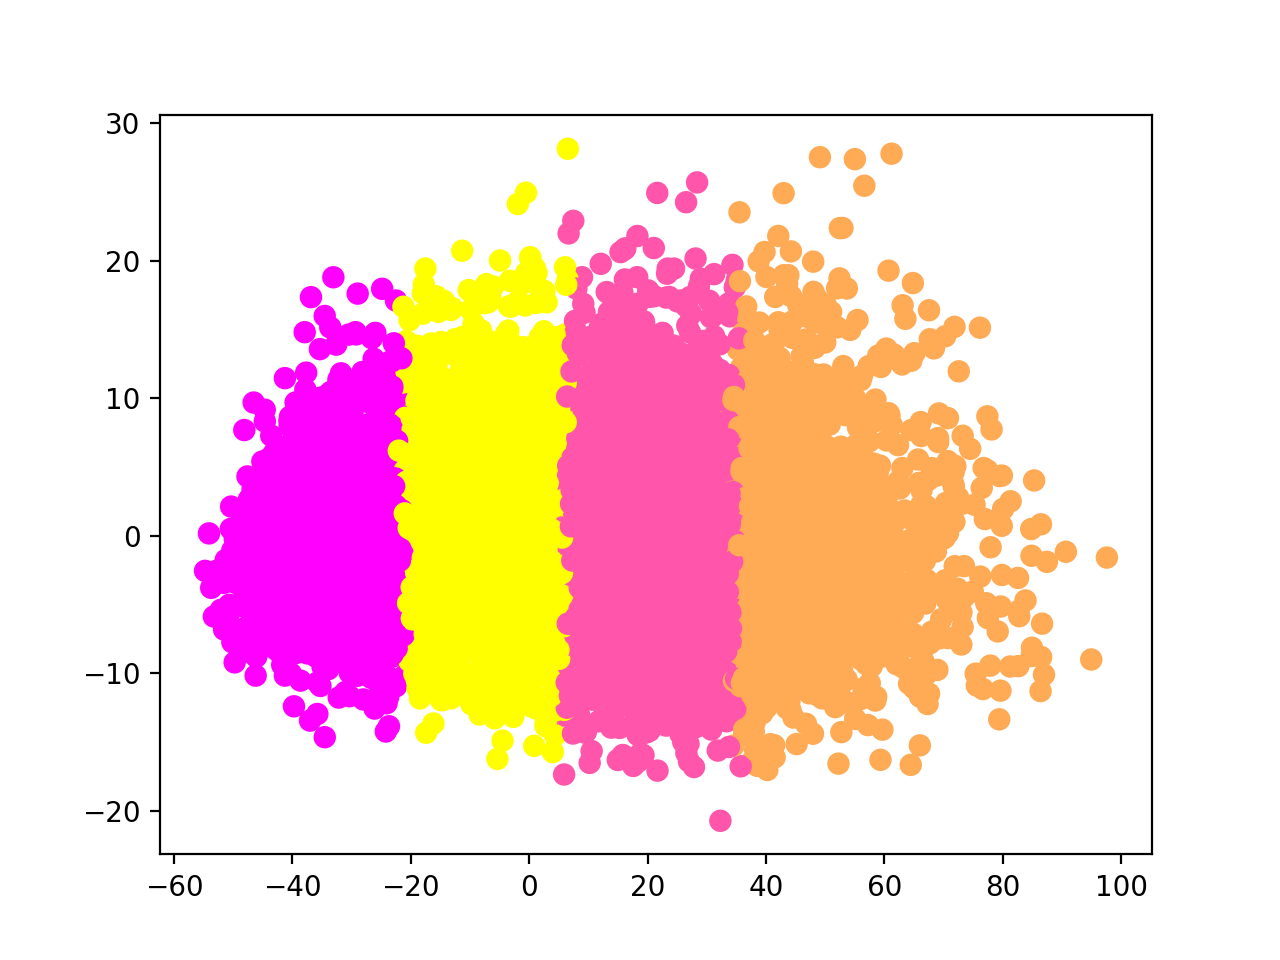

In [227]:
# Plot labeled points
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels, s=50, cmap="spring")
# Add cluster centers
#plt.scatter(centers[:, 0], centers[:, 1], c='black', marker="x", s=200, alpha=0.75)

In [228]:
# K-Means standardized

labels, centers = full_kmeans(weather_std, 4)

<IPython.core.display.Javascript object>


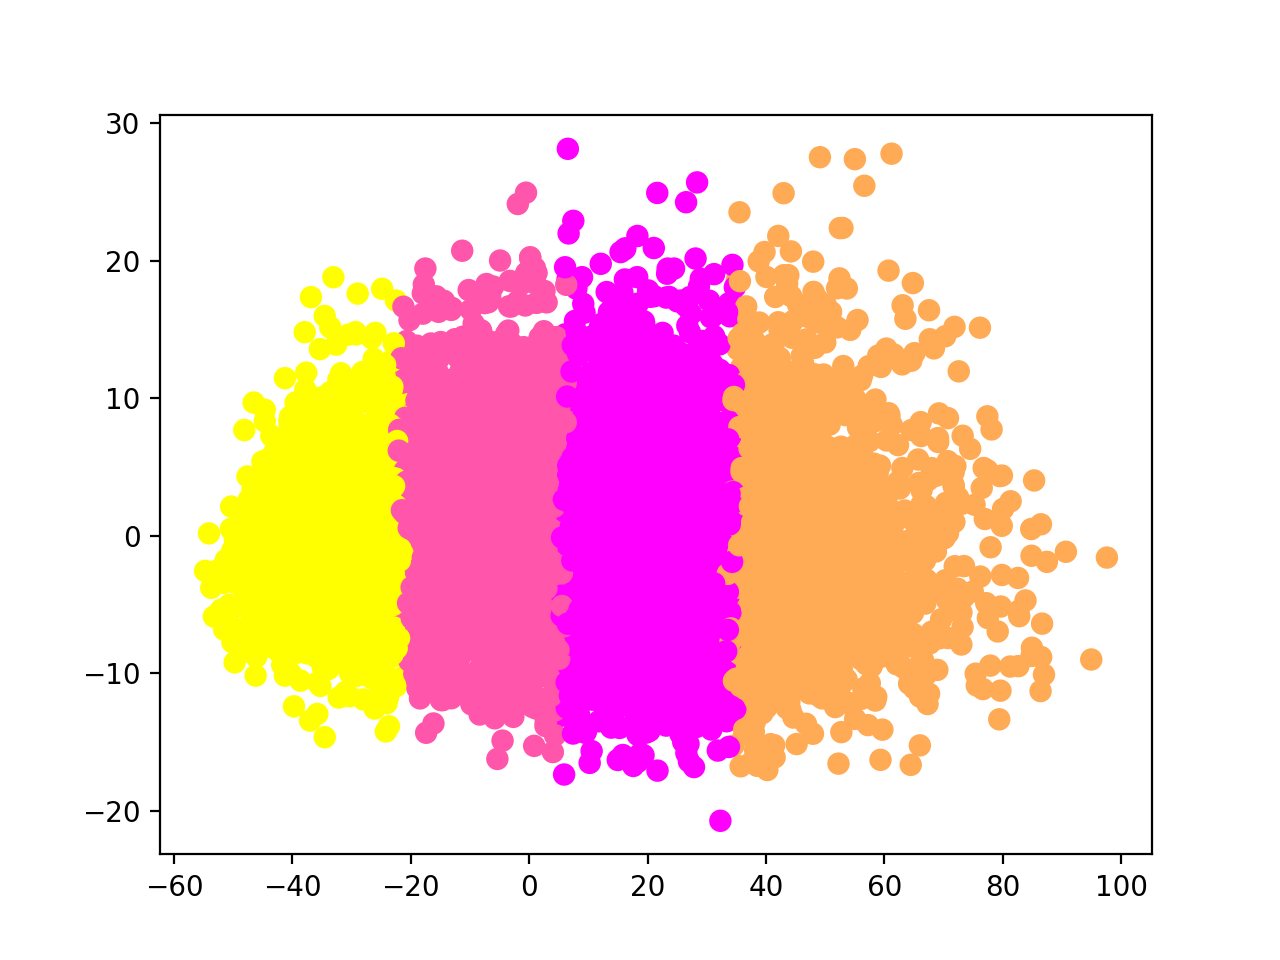

In [229]:
# Plot labeled points
plt.scatter(weather_two[:,0], weather_two[:,1], c=labels, s=50, cmap="spring")
# Add cluster centers
#plt.scatter(centers[:, 0], centers[:, 1], c='black', marker="x", s=200, alpha=0.75)